/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


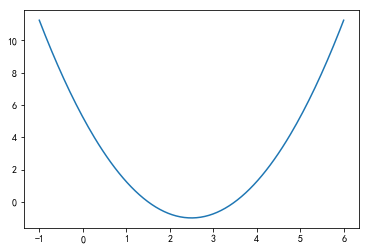

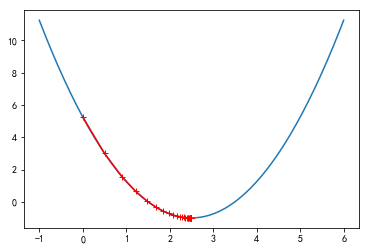

In [1]:
'''一、梯度优化：
1），Gradient descent；
2），将上述过程对象化；
3），测试不同的学习率对结果的影响；
4），增加最大迭代次数的限制，再次对象化；
5），再次设定eta=1.1的情况，比较与上面的区别。
 '''

# 1，Gradient descent:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-1., 6, 150, dtype='complex128')
y = (x - 2.5) ** 2 - 1.

plt.plot(x, y)
plt.show()

epsilon = 1e-8  # 每步最小移动，小于这个说明达到收敛
eta = 0.1  # 学习率
def J(x):
    return (x - 2.5) ** 2 - 1.
def dJ(x):
    return 2 * (x - 2.5)
theta = 0
history_theta = [theta]
while True:
    gradient = dJ(theta)
    last_theta = theta
    theta = theta - eta * gradient
    history_theta.append(theta)
    if abs(J(last_theta) - J(theta)) < epsilon:
        break

plt.plot(x, J(x))
plt.plot(np.array(history_theta), J(np.array(history_theta)), color='r', marker='+')
plt.show()

In [2]:
# 2，将上述过程对象化：
history_theta = []

def gradient_descent(initial_theta, eta, epsilon=1e-8):
    theta = initial_theta
    history_theta.append(theta)
    
    while True:
        gradient = dJ(theta)
        last_theta = theta
        theta = theta - eta * gradient
        history_theta.append(theta)
        if abs(J(last_theta) - J(theta)) < epsilon:
            break

def print_history():
    plt.plot(x, J(x))
    plt.plot(np.array(history_theta), J(np.array(history_theta)), color='r', marker='+')
    plt.show()

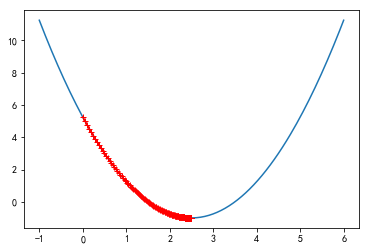

OverflowError: (34, 'Numerical result out of range')

In [3]:
# 3，测试不同的学习率对结果的影响：
history_theta = []
eta = 0.01
gradient_descent(0, eta)
print_history()

history_theta = []
eta = 1.1
gradient_descent(0, eta)
print_history()

In [4]:
# 4，增加最大迭代次数的限制，再次对象化：
history_theta = []

def gradient_descent(initial_theta, eta, n_iters = 1e4, epsilon=1e-8):
    theta = initial_theta
    history_theta.append(theta)
    i_iter = 0
    while i_iter < n_iters:
        gradient = dJ(theta)
        last_theta = theta
        theta = theta - eta * gradient
        history_theta.append(theta)
        if abs(J(last_theta) - J(theta)) < epsilon:
            break
        i_iter += 1
    return

def print_history():
    plt.plot(x, J(x))
    plt.plot(np.array(history_theta), J(np.array(history_theta)), color='r', marker='+')
    plt.show()

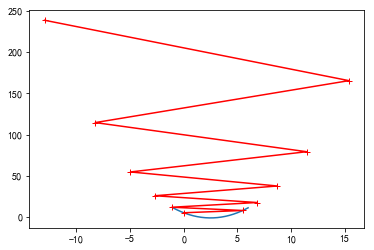

In [5]:
# 5，再次设定eta=1.1的情况，比较与上面的区别：
history_theta = []
eta = 1.1
gradient_descent(0, eta, n_iters=10)
print_history()

In [6]:
'''二、剃度验证：
1，定义一个梯度检验函数；
2，验证。'''

import numpy as np
import random

# 1，定义一个梯度检验函数：
def grad_check_naive(f, theta, h):
    """
    梯度检查器
    :param f: 输入theta，可返回(原损失函数值和对应梯度值构成的元组)
    :param theta: 入参(n维向量)
    :param h: 极限中所取的一个很小的值
    :return:
    """
    f_theta, grad = f(theta)
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        index = it.multi_index
        theta_i = theta[index]
        f_res1 = f(theta_i + h)[0]
        f_res2 = f(theta_i - h)[0]
        res = (f_res1 - f_res2) / (2 * h)

        reldiff = abs(res - grad[index])
        if reldiff > h:
            print("校验失败...")
            print("首次校验失败index为：", index)
            print("实际求出的梯度为：%f,校验求出的梯度为：%f" % (grad[index], res))
            return

        it.iternext()

    print("校验通过...")

def sanity_check():
    """
    Some basic sanity checks.
    """
    quad = lambda x: (np.sum(x ** 2), x * 2)

    print("Running sanity checks...")
    grad_check_naive(quad, np.array(123.456), 1e-4)  # scalar test
    grad_check_naive(quad, np.random.randn(3, ), 1e-4)  # 1-D test
    grad_check_naive(quad, np.random.randn(4, 5), 1e-4)  # 2-D test
    print("")


def my_sanity_checks():
    def sigmoid(x):
        return 1. / (1 + np.exp(-x))

    def sigmoid_grad(x):
        return sigmoid(x) * (1 - sigmoid(x))

    quad = lambda x: (sigmoid(x), sigmoid_grad(x))
    print("Running my sanity checks...")
    grad_check_naive(quad, np.random.randn(1, 10), 1e-4)  # scalar test
    print("my check is pass ...")

In [7]:
# 2，验证：
sanity_check()
my_sanity_checks()

Running sanity checks...
校验通过...
校验通过...
校验通过...

Running my sanity checks...
校验通过...
my check is pass ...


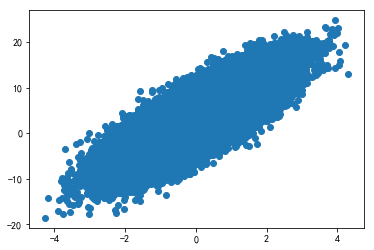

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


In [8]:
'''三、SGD：对比梯度下降与随机梯度下降用时差异：
1，梯度下降法；
2,随机梯度下降。'''

import numpy as np
import matplotlib.pyplot as plt

m = 100000

x = np.random.normal(size=m)
X = x.reshape(-1, 1)
y = 4. * x + 3 + np.random.normal(0, 3, size=m)

plt.scatter(x, y)
plt.show()


# 1，梯度下降法：
def J(theta, X_b, y):
    try:
        return np.sum((y - X_b.dot(theta)) ** 2) / len(y)
    except:
        return float('inf')
    
def dJ(theta, X_b, y):
    res = np.empty(len(theta))
    res[0] = np.sum(X_b.dot(theta) - y)
    for i in range(1, len(theta)):
        res[i] = (X_b.dot(theta) - y).dot(X_b[:,i])
    
    return res * 2 / len(X_b)

def gradient_descent(X_b, y, initial_theta, eta, n_iters=1e4, epsilon=1e-8):

    theta = initial_theta
    cur_iter = 0

    while cur_iter < n_iters:
        gradient = dJ(theta, X_b, y)
        last_theta = theta
        theta = theta - eta * gradient
        if (abs(J(theta, X_b, y) - J(last_theta, X_b, y)) < epsilon):
            break

        cur_iter += 1

    return theta

X_b = np.hstack([np.ones((len(X), 1)), X])
initial_theta = np.zeros(X_b.shape[1])
eta = 0.01
%time
theta = gradient_descent(X_b, y, initial_theta, eta)

In [9]:
# 2,随机梯度下降法：
def dJ_sgd(theta, X_b_i, y_i):
    return 2 * X_b_i.T.dot(X_b_i.dot(theta) - y_i)

def sgd(X_b, y, initial_theta, n_iters):
    # 此处是为了让学习率越来越小，避免直接跳过最优解
    # 这是由于SGD本身的特性决定的
    # t0和t1是两个超参数，可自行调节
    t0, t1 = 5, 50
    def learning_rate(t):
        return t0 / (t + t1)
    
    theta = initial_theta
    for cur_iter in range(n_iters):
        # 随机取一个数据
        rand_i = np.random.randint(len(X_b))
        gradient = dJ_sgd(theta, X_b[rand_i], y[rand_i])
        # 我们选用的是当前步数的倒数作为学习率，这样就实现了学习率越来越小
        # 但是为了防止一开始学习率过大，我们分子和分母各增加参数进行调节
        theta = theta - learning_rate(cur_iter) * gradient
    return theta

%time
X_b = np.hstack([np.ones((len(X), 1)), X])
initial_theta = np.zeros(X_b.shape[1])
theta = sgd(X_b, y, initial_theta, n_iters=m//3)
print(theta)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
[2.91802253 3.96276074]


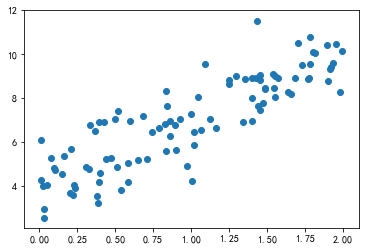

In [10]:
'''四、梯度下降法优化线性回归模型：
1, 定义自己的线性回归模型；
2，对比sklearn中的线性回归。'''

import numpy as np
import matplotlib.pyplot as plt

# 设定一个随机种子，保证我们每次得到的结果一致
np.random.seed(666)
x = 2. * np.random.random(size=100)
y = x * 3. + 4. + np.random.normal(size=100)

plt.scatter(x, y)
plt.show()

# 1, 定义自己的线性回归模型：
# 定义线性回归的损失函数：
def J(theta, X_b, y):
    try:
        return np.sum((y - X_b.dot(theta)) ** 2) / len(X_b)
    except:
        return float('inf')

def dJ(theta, X_b, y):
    res = np.empty(len(theta))
    res[0] = np.sum(X_b.dot(theta) - y)
    for i in range(1, len(theta)):
        res[i] = (X_b.dot(theta) - y).dot(X_b[:,i])
    
    return res * 2 / len(X_b)

def gradient_descent(X_b, y, initial_theta, eta, n_iters = 1e4, epsilon=1e-8):
    
    theta = initial_theta
    cur_iter = 0

    while cur_iter < n_iters:
        gradient = dJ(theta, X_b, y)
        last_theta = theta
        theta = theta - eta * gradient
        if(abs(J(theta, X_b, y) - J(last_theta, X_b, y)) < epsilon):
            break
            
        cur_iter += 1

    return theta

X_b = np.hstack([np.ones((len(x), 1)), x.reshape(-1,1)])
initial_theta = np.zeros(X_b.shape[1])
eta = 0.01
theta = gradient_descent(X_b, y, initial_theta, eta)

In [11]:
# 2，对比sklearn中的线性回归：
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_b, y)
print(lr.coef_, lr.intercept_)

[0.         3.00517447] 4.023696672103901
